Install

In [108]:
!pip install --upgrade pandas
!pip install --upgrade gensim
!pip install --upgrade pythainlp
!pip install --upgrade pyLDAvis
!pip install text2emotion
!pip install fairseq
!pip install sacremoses sentencepiece
!pip install https://github.com/PyThaiNLP/pythainlp/archive/dev.zip

Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.4)
Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)
Requirement already up-to-date: pythainlp in /usr/local/lib/python3.7/dist-packages (2.3.1)
Requirement already up-to-date: pyLDAvis in /usr/local/lib/python3.7/dist-packages (3.3.1)
  Using cached https://github.com/PyThaiNLP/pythainlp/archive/dev.zip
  Created wheel for pythainlp: filename=pythainlp-2.3.1-cp37-none-any.whl size=11617888 sha256=beadc763cadecef0db2172e7a9b8db305f417bb32176e9fb4f3124cde28070df
  Stored in directory: /tmp/pip-ephem-wheel-cache-21od1e6e/wheels/79/4e/1e/26f3198c6712ecfbee92928ed1dde923a078da3d222401cc78
Successfully built pythainlp


In [118]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

import pandas as pd
import numpy as np
import re
import string
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import pythainlp 
from pythainlp.translate import EnThTranslator, ThEnTranslator
from pythainlp.translate import download_model_all
from pythainlp.corpus.common import *
from pythainlp.util import normalize
from pythainlp import Tokenizer
download_model_all()

import text2emotion as te

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

import gensim
from gensim import corpora, models, similarities, downloader

Import source data

In [110]:
url = 'https://raw.githubusercontent.com/PaoLastHope/BADS7105/012d3c593aefc5821bd07d549674f5cae46c2fcc/HOMEWORK%2011/CustomerReviews.csv'
df = pd.read_csv(url)
df.head(5)

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating
0,1,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,7b16469831074f7abc7824745ee75212,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,5.0
1,2,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,pakkaramonpondej,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่งดี,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,5.0
2,3,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,saanowy,ชาบูพรีเมี่ยมสไตล์ญี่ปุ่น เนื้อดีมากกก,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,4.0
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0
4,5,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,665a902b335b434ab489f00f2fbb477e,อาหารมีคุณภาพ บริการดีค่ะ,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,5.0


# Tokenize Words

In [111]:
# Build thai words for tokenizer
th_words = []
th_words.extend(list(thai_words())) 
th_words.extend(list(thai_stopwords()))
th_words.extend(list(thai_negations()))
th_words.extend(list(countries()))
th_words.extend(list(provinces()))
# specific words
th_words.extend(['เทมปุระ', 'บุฟเฟ่', 'เด็ดๆ','เดอะแกงค์', 'เพลินๆ', 'เบาๆ','หวานๆ', 'เนื้อออส']) 
# additional words
th_words.extend(['ชั้น G', 'ยูเนี่ยนมอลล์', 'โมโม่', 'เดอะมอลล์', 'บางกะปิ', 'ชาบูชิ', 'นารายพิซเซอเรีย']) 
th_words = set(th_words)

# remove from result list
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = [' ', '  ', '\n', 'ร้าน', '(', ')', ':', '–', '"', ',']
screening_words = stopwords + removed_words

def tokenize_with_space(text):
  text = normalize(str(text))
  custom_tokenizer = Tokenizer(th_words)
  words = custom_tokenizer.word_tokenize(text=text)
  words = [x for x in words if (x not in removed_words)]
  print(words)
  merged = ''
  for word in words:
    word = normalize(word)
    if word not in screening_words:
      merged = merged + ',' + word
  return merged[1:]

In [112]:
print(list(pythainlp.corpus.thai_stopwords()))

['เฉยๆ', 'สุด', 'ด้วยเหมือนกัน', 'ครานั้น', 'หาก', 'เรียก', 'เกี่ยวกัน', 'ให้', 'คง', 'ผล', 'ก็ได้', 'ประสบ', 'ปรับ', 'ข้าพเจ้า', 'ฉะนั้น', 'เข้า', 'จะได้', 'เช่นที่เคย', 'อื่นๆ', 'คงจะ', 'แค่เพียง', 'กันเถอะ', 'คงอยู่', 'เผื่อว่า', 'อันจะ', 'เยอะแยะ', 'มิ', 'ใกล้', 'เป็นการ', 'เป็นที่', 'ซึ่งกันและกัน', 'พวกเธอ', 'เมื่อคราวก่อน', 'แห่งไหน', 'ทําให้', 'บัดดล', 'จนกว่า', 'เล่าว่า', 'เพื่อที่', 'บ่อยกว่า', 'พร้อมกับ', 'เสียจนกระทั่ง', 'ที่ละ', 'การ', 'แค่นี้', 'ทั้งตัว', 'ทีเถอะ', 'อันที่จริง', 'เสีย', 'ถูกๆ', 'บ่อยๆ', 'นอกจากนั้น', 'ผิดๆ', 'ฉะนี้', 'ทุกหน', 'กันดีกว่า', 'เมื่อเย็น', 'เชื่อ', 'ตน', 'จัด', 'เหตุนั้น', 'เช่นกัน', 'นับแต่', 'เสมือนกับ', 'ถึงเมื่อไร', 'อย่างไรก็', 'ที่แห่งนั้น', 'เมื่อใด', 'รวดเร็ว', 'ลง', 'หลาย', 'มุ่งหมาย', 'เหตุไร', 'ซะจนกระทั่ง', 'ก็ดี', 'ทุกที', 'พวกนั้น', 'ที่ไหน', 'ตนเอง', 'มากมาย', 'ถูกต้อง', 'เท่า', 'เท่าไหร่', 'เปิดเผย', 'กันและกัน', 'ทุกวันนี้', 'มี', 'หากแม้นว่า', 'พอ', 'นี้', 'ทํา', 'สิ้น', 'อย่างน้อย', 'น่ะ', 'กำลัง', 'นอกนั้น', 'ภายภาค', 'ฯ', 

In [113]:
df['Review_tokenized'] = df['Review'].apply(lambda x: tokenize_with_space(x))
df

['ที่', 'สำคัญ', 'ของ', 'นี้', 'คือ', 'บริการ', 'ดีมาก', 'พนักงาน', 'น่ารัก', 'สุดๆ', 'สะอาดสะอ้าน', 'ใส่ใจ', 'ค่อนข้าง', 'ประทับใจ', 'กับ', 'การ', 'บริการ', 'รสชาติ', 'อาหาร', 'อันนี้', 'แปลกใหม่', 'เซ็ท', '560', 'บาท', 'อาหาร', 'จำกัด', 'ไม่', 'ได้', 'หลากหลาย', 'แต่เพียง', 'พอกับ', 'ความต้องการ', 'เรา', 'ไม่', 'กิน', 'เนื้อ', 'กิน', 'สัน', 'คอ', '4', 'ถาด', 'เป็ด', '1', 'แฟน', 'กิน', 'เนื้อ', 'คุณภาพดี', 'น้ำ', 'ซุป', 'ดำ', 'กับ', 'เผ็ด', 'ที่', 'สำคัญ', 'คือ', 'น้ำจิ้ม', 'อร่อย', 'มาก', 'ไม่', 'เคย', 'กิน', 'รสชาติ', 'แบบนี้', 'มา', 'ก่อน', 'เป็น', 'เต้าเจี้ยว', 'นิดๆ', 'แต่ก็', 'ไม่', 'ได้', 'เคลม', 'ก็', 'รสชาติ', 'ดี', 'นะ', 'ถาม', 'ราคา', 'โดยรวม', 'ก็', 'ถือว่า', 'คุ้ม', 'เพราะว่า', 'โมจิ', 'อร่อย', 'มาก', 'ไอติม', 'ก็', 'อร่อย', 'ไม่ต้อง', 'ออก', 'ไป', 'กิน', 'ข้างนอก', 'สรุป', 'รวมๆ', 'ละ', 'กัน', 'ว่า', 'ประทับใจ', 'ใน', 'บริการ', 'และ', 'คุณภาพ', 'ของ', 'อาหาร']
['นึกถึง', 'ชาบู', 'ญี่ปุ่น', 'ยังไง', 'ก็', 'ต้อง', 'คิดถึง', 'โมโม่', 'พาราไดซ์', 'คุณภาพ', 'เค้า', 'มาตรา', '

,Review ID,Restaurant_ID,Restaurant,User,Headline,Review,Rating,Review_tokenized
0,1,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,7b16469831074f7abc7824745ee75212,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,ที่สำคัญของร้านนี้คือบริการดีมากพนักงานน่ารักส...,5.0,"บริการ,ดีมาก,พนักงาน,น่ารัก,สะอาดสะอ้าน,ใส่ใจ,..."
1,2,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,pakkaramonpondej,รสชาติเหมือนทุกสาขา แต่สาขานี้ บริการดี ที่นั่งดี,นึกถึงชาบูญี่ปุ่นยังไงก็ต้อง คิดถึงโมโม่ พาราไ...,5.0,"นึกถึง,ชาบู,ญี่ปุ่น,คิดถึง,โมโม่,พาราไดซ์,คุณภ..."
2,3,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,saanowy,ชาบูพรีเมี่ยมสไตล์ญี่ปุ่น เนื้อดีมากกก,มาทานช่วงนี้ สามารถนั่งโต๊ะเดียวกัน หม้อเดียวก...,4.0,"ทาน,นั่ง,โต๊ะ,หม้อ,โต๊ะ,ยังมี,ฉาก,กั้น,น้ำ,ซุป..."
3,4,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,ployynp,เนื้อดี ไอติมดี คุ้มค่าดี,ถ้านึกถึงชาบูที่มีเนื้อเน้นๆ ในราคาไม่โหดจนเกิ...,4.0,"นึกถึง,ชาบู,เนื้อ,ราคา,โหด,เกินไป,นึกถึง,โมโม่..."
4,5,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,665a902b335b434ab489f00f2fbb477e,อาหารมีคุณภาพ บริการดีค่ะ,เดินมาหน้าร้านแล้วได้กลิ่นชาบูหอมมาก ๆ ประกอบ...,5.0,"เดิน,หน้า,ได้กลิ่น,ชาบู,หอ,มมาก,โปร,บัตรเครดิต..."
5,6,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,12f2b56b28bb4849a92690cedc1cc50a,กินให้อิ่ม ที่ momo,ร้านบุฟเฟ่ ชาบูแนวญี่ปุ่น สายเนื้อหมู เนื้อวัว...,4.0,"บุฟเฟ่,ชาบู,แนว,ญี่ปุ่น,สาย,เนื้อหมู,เนื้อวัว,..."
6,7,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,f2628bf47a394345b133fec76a79661d,ชาบู - สุกกี้สไลต์ญี่ปุ่นที่แท้ทรู,Number 20 : โมโม – พาราไดส์ (สาขาเดอะมอลบางกะป...,4.0,"Number,20,โม,โม,พารา,ได,ส์,สาขา,เดอะ,มอ,ล,บางก..."
7,8,352696Px-mo-mo-paradise-เดอะมอลล์-บางกะปิ,Mo-Mo-Paradise (โม โม พาราไดซ์) เดอะมอลล์ บางกะปิ,backscrash,ร้านชาบูเฟรนไชส์ ที่ราคาเหมาะสมกับคุณภาพ ถือว่...,ร้านชาบูเฟรนไชส์รสชาติดีมากคุ้มค่าเหมาะสมกับรา...,4.0,"ชาบู,เฟรนไชส์,รสชาติ,ดีมาก,คุ้มค่า,เหมาะสม,ราค..."
8,9,4621tm-shabushi-เดอะมอลล์บางกะปิ-ชั้น-g,Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,a477a5812ada4d5b80fd04fca22bdbca,อร่อยคุ้ม ของทานเล่นเยอะมาก,มา านที่ขาบูชิต้องมาตอนหิว ไม่งั้นจะไม่คุ้มนะค...,4.0,"มาน,ขา,บู,ชิ,ตอน,หิว,ไม่งั้น,คุ้ม,ฮ่า,เมนู,ของ..."
9,10,4621tm-shabushi-เดอะมอลล์บางกะปิ-ชั้น-g,Shabushi (ชาบูชิ) เดอะมอลล์บางกะปิ ชั้น G,fd2ba94ec1bc4948ae109e2cb6c9cbc6,ทานอีก ชอบกุ้งทอดเทมปุระ,ใครชอบกุ้งทอดเทมปุระ แค่กุ้งเทมปุระก็คุ้มแล้ว ...,3.0,"ชอบ,กุ้ง,ทอด,เทมปุระ,กุ้ง,เทมปุระ,คุ้ม,ทาน,ดึก..."


# Simple words count

In [114]:
df1 = df
df1 = (df1['Review_tokenized'].str.split(pat=',', expand=True)
              .stack()
              .value_counts()
              .rename_axis('vals')
              .reset_index(name='count'))
print (df1)

        vals  count
0        น้ำ     28
1        ทาน     25
2        กิน     23
3      อร่อย     22
4      เลือก     19
..       ...    ...
596      จอง      1
597   เลี่ยน      1
598  วันหยุด      1
599      แฟน      1
600    เครือ      1

[601 rows x 2 columns]


# Text to Emotion

In [115]:
# df2 = df
# df2['Trans'] = df2['Review'].apply(lambda x: ThEnTranslator().translate(x))
# df2['Emotion'] = df2['Trans'].apply(lambda x: te.get_emotion(x))

In [116]:
# df2[['Review','Trans','Emotion']].head()

# Create Dictionary



In [173]:
documents = df['Review_tokenized'].to_list()
texts = [[text for text in doc.split(',')] for doc in documents]
texts = [x for x in texts if (x not in removed_words)]
dictionary = gensim.corpora.Dictionary(texts)

print(dictionary.token2id.keys())

dict_keys(['1', '4', '560', 'กิน', 'ข้างนอก', 'ความต้องการ', 'คอ', 'คุณภาพ', 'คุณภาพดี', 'คุ้ม', 'จำกัด', 'ซุป', 'ดำ', 'ดี', 'ดีมาก', 'ถาด', 'ถาม', 'น่ารัก', 'น้ำ', 'น้ำจิ้ม', 'บริการ', 'บาท', 'ประทับใจ', 'พนักงาน', 'พอกับ', 'รสชาติ', 'ราคา', 'สรุป', 'สะอาดสะอ้าน', 'สัน', 'หลากหลาย', 'อร่อย', 'อันนี้', 'อาหาร', 'เคลม', 'เซ็ท', 'เต้าเจี้ยว', 'เนื้อ', 'เป็ด', 'เผ็ด', 'แบบนี้', 'แปลกใหม่', 'แฟน', 'โดยรวม', 'โมจิ', 'ใส่ใจ', 'ไม่ต้อง', 'ไอติม', '21', '30', '9', 'CTW', 'Terminal', 'กา', 'การงด', 'คิดถึง', 'ชาบู', 'ญี่ปุ่น', 'ฐาน', 'ทะยอย', 'ทำงาน', 'ที่ทาง', 'นาที', 'นึกถึง', 'พนักงานบริการ', 'พระราม', 'พรีเมียม', 'พาราไดซ์', 'มาตรา', 'มีโอ', 'รายละเอียด', 'ลูกค้า', 'สมาทาน', 'สาขา', 'สู้', 'ออร์เดอร์', 'เครื่องดื่ม', 'เค้า', 'เจอ', 'เป็นกันเอง', 'เหวี่ยง', 'แจ้ง', 'โมโม่', 'โอเค', '++', '2', '555', '600', '::', 'กก', 'กรุบ', 'กั้น', 'ของหวาน', 'คนละ', 'คาว', 'คุ', 'คุ้มค่า', 'จาน', 'จิ้ม', 'จืด', 'ฉาก', 'ชอบ', 'ชาเขียว', 'ชิ้น', 'ซอย', 'ซอส', 'ตก', 'ตะ', 'ตัก', 'ตามน้ำ', 'ต่างกัน', 'ถั่ว', 

In [174]:
gensim_corpus = [dictionary.doc2bow(text, allow_update=True) for text in texts]
word_frequencies = [[(dictionary[id], frequence) for id, frequence in couple] for couple in gensim_corpus]

In [179]:
num_topics = 4
chunksize = 1000 # size of the doc looked at every pass
passes = 50 # number of passes through documents
iterations = 20
eval_every = 1  # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every, per_word_topics=True )

# Display Topic Model

In [180]:
vis = pyLDAvis.gensim_models.prepare(model, gensim_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.093441  0.070471       1        1  31.848974
3      0.090875  0.046794       2        1  30.423443
2      0.042173 -0.028271       3        1  19.277165
0     -0.039607 -0.088994       4        1  18.450418, topic_info=        Term       Freq      Total Category  logprob  loglift
329        -  11.000000  11.000000  Default  30.0000  30.0000
267     กุ้ง   9.000000   9.000000  Default  29.0000  29.0000
283  เทมปุระ   5.000000   5.000000  Default  28.0000  28.0000
31     อร่อย  16.000000  16.000000  Default  27.0000  27.0000
73      สาขา   9.000000   9.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
37     เนื้อ   2.014747  13.221459   Topic4  -4.8009  -0.1913
85         2   1.394813   5.500521   Topic4  -5.1686   0.3180
31     อร่อย   2.014746  16.522491   Topic4  -4.8009  -0.4141
3        กิน   1.394818  16.957678   Topic4  -5.1686  -0.8079
26      ราคา   0.774880  13.160850   Topic4  -5.7564  -1.1422

[249 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
329       2  0.713100      -
329       3  0.267413      -
265       3  0.763730     ..
0         1  0.201490      1
0         2  0.604471      1
...     ...       ...    ...
176       1  0.705710     ไว
47        1  0.473299  ไอติม
47        2  0.315532  ไอติม
47        3  0.157766  ไอติม
47        4  0.157766  ไอติม

[305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

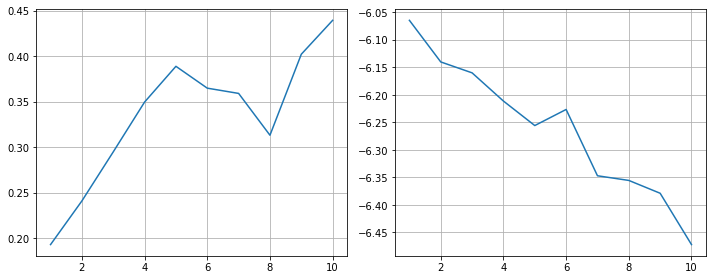

In [154]:
score = []
for k in range(1,11):
    model = gensim.models.LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, 
                        alpha='auto', eta='auto', 
                        iterations=iterations, num_topics=k, 
                        passes=passes, eval_every=eval_every)
    coherence_model_lda = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    score.append((k,coherence_model_lda.get_coherence(),model.log_perplexity(gensim_corpus)))

x, y, z = zip(*score)
plt.figure(figsize=(10,4), tight_layout=True)
plt.subplot(121)
plt.plot(x, y, label='Coherence')
plt.grid(True)
plt.subplot(122)
plt.plot(x, z, label='perplexity')
plt.grid(True)
plt.show()